# exp111_疑似距離ML
疑似距離をMLで予測

In [24]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, accuracy_score
pd.set_option('display.max_rows', 100)
from math import * 
import scipy.optimize as opt
import multiprocessing
pd.set_option('display.max_columns', 50)

In [25]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [26]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

In [27]:
g1 = ['2020-05-14-US-MTV-1', '2020-05-14-US-MTV-2', '2020-05-21-US-MTV-1', '2020-05-21-US-MTV-2',
      '2020-05-29-US-MTV-1', '2020-05-29-US-MTV-2', '2020-06-04-US-MTV-1', '2020-06-05-US-MTV-1',
      '2020-06-05-US-MTV-2', '2020-06-11-US-MTV-1', '2020-07-08-US-MTV-1', '2020-07-17-US-MTV-1',
      '2020-07-17-US-MTV-2', '2020-08-03-US-MTV-1', '2020-08-06-US-MTV-2', '2020-09-04-US-SF-1',
      '2020-09-04-US-SF-2',  '2021-01-04-US-RWC-1', '2021-01-04-US-RWC-2',
      '2020-05-15-US-MTV-1', '2020-05-28-US-MTV-1', '2020-05-28-US-MTV-2', '2020-06-04-US-MTV-2',
      '2020-06-10-US-MTV-1', '2020-06-10-US-MTV-2', '2020-08-03-US-MTV-2', '2020-08-13-US-MTV-1',
      '2021-03-16-US-MTV-2']

g2 = ['2021-01-05-US-SVL-1', '2021-01-05-US-SVL-2', '2021-04-15-US-MTV-1', 
      '2021-03-25-US-PAO-1', '2021-04-02-US-SJC-1', '2021-04-08-US-MTV-1']

g3 = ['2021-03-10-US-SVL-1', '2021-04-26-US-SVL-1', '2021-04-26-US-SVL-2']

g4 = ['2021-04-28-US-MTV-1', '2021-04-29-US-MTV-1', 
      '2021-03-16-US-RWC-2', '2021-04-21-US-MTV-1', '2021-04-28-US-MTV-2', '2021-04-29-US-MTV-2']

g5 = ['2021-04-22-US-SJC-1', '2021-04-28-US-SJC-1', '2021-04-29-US-SJC-2', 
      '2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3']

In [28]:
target_g = g5

# utils

In [29]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [30]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [31]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [32]:
# ground_truth
def get_ground_truth():
    p = pathlib.Path(INPUT)
    gt_files = list(p.glob('train/*/*/ground_truth.csv'))

    gts = []
    for gt_file in gt_files:
        gts.append(pd.read_csv(gt_file))
    ground_truth = pd.concat(gts)

    return ground_truth

In [33]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [34]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [35]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = pd.read_csv(INPUT + '/prep/ground_truth_train.csv')
    return base_train, base_test, sample_sub, ground_truth

In [36]:
def ecef2lla(x, y, z):
    # x, y and z are scalars or vectors in meters
    x = np.array([x]).reshape(np.array([x]).shape[-1], 1)
    y = np.array([y]).reshape(np.array([y]).shape[-1], 1)
    z = np.array([z]).reshape(np.array([z]).shape[-1], 1)

    a=6378137
    a_sq=a**2
    e = 8.181919084261345e-2
    e_sq = 6.69437999014e-3

    f = 1/298.257223563
    b = a*(1-f)

    # calculations:
    r = np.sqrt(x**2 + y**2)
    ep_sq  = (a**2-b**2)/b**2
    ee = (a**2-b**2)
    f = (54*b**2)*(z**2)
    g = r**2 + (1 - e_sq)*(z**2) - e_sq*ee*2
    c = (e_sq**2)*f*r**2/(g**3)
    s = (1 + c + np.sqrt(c**2 + 2*c))**(1/3.)
    p = f/(3.*(g**2)*(s + (1./s) + 1)**2)
    q = np.sqrt(1 + 2*p*e_sq**2)
    r_0 = -(p*e_sq*r)/(1+q) + np.sqrt(0.5*(a**2)*(1+(1./q)) - p*(z**2)*(1-e_sq)/(q*(1+q)) - 0.5*p*(r**2))
    u = np.sqrt((r - e_sq*r_0)**2 + z**2)
    v = np.sqrt((r - e_sq*r_0)**2 + (1 - e_sq)*z**2)
    z_0 = (b**2)*z/(a*v)
    h = u*(1 - b**2/(a*v))
    phi = np.arctan((z + ep_sq*z_0)/r)
    lambd = np.arctan2(y, x)

    return phi*180/np.pi, lambd*180/np.pi, h

In [37]:
def WGS84_to_ECEF(lat, lon, alt):
    # convert to radians
    rad_lat = lat * (np.pi / 180.0)
    rad_lon = lon * (np.pi / 180.0)
    a    = 6378137.0
    # f is the flattening factor
    finv = 298.257223563
    f = 1 / finv   
    # e is the eccentricity
    e2 = 1 - (1 - f) * (1 - f)    
    # N is the radius of curvature in the prime vertical
    N = a / np.sqrt(1 - e2 * np.sin(rad_lat) * np.sin(rad_lat))
    x = (N + alt) * np.cos(rad_lat) * np.cos(rad_lon)
    y = (N + alt) * np.cos(rad_lat) * np.sin(rad_lon)
    z = (N * (1 - e2) + alt)        * np.sin(rad_lat)
    return x, y, z

# 疑似距離を算出

In [38]:
def prepare_calc_baseline(df, is_train):
    light_speed = 299_792_458
    omega_e = 7.2921151467e-5
    
    df['sat'] = df['svid'].astype('str') + '_' + df['signalType']
    df['isrbM'] = df.groupby('sat')['isrbM'].transform('median')
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    
    # Corrected pseudorange according to data instructions
    df['correctedPrM'] = df['rawPrM'] + \
                         df['satClkBiasM'] - \
                         df['isrbM'] - \
                         df['ionoDelayM'] - \
                         df['tropoDelayM']
    
    # Time it took for signal to travel
    df['transmissionTimeSeconds'] = df['correctedPrM'] / light_speed
    
    # Compute true sat positions at arrival time
    df['xSatPosMRotated'] = \
        np.cos(omega_e * df['transmissionTimeSeconds']) * df['xSatPosM'] \
        + np.sin(omega_e * df['transmissionTimeSeconds']) * df['ySatPosM']

    df['ySatPosMRotated'] = \
        - np.sin(omega_e * df['transmissionTimeSeconds']) * df['xSatPosM'] \
        + np.cos(omega_e * df['transmissionTimeSeconds']) * df['ySatPosM']

    df['zSatPosMRotated'] = df['zSatPosM']
    
    if is_train:
        gt = pd.read_csv(INPUT + '/prep/ground_truth_train.csv')
        gt['phone'] = gt['collectionName'] + '_' + gt['phoneName']
        gt = gt[['phone', 'millisSinceGpsEpoch', 'heightAboveWgs84EllipsoidM', 'latDeg', 'lngDeg']].copy()
        df2 = pd.DataFrame()
        
        for phone in df['phone'].unique():
            df_tmp = df[df['phone']==phone].copy()
            gt_tmp = gt[gt['phone']==phone].copy()
            del gt_tmp['phone']
            df_tmp = pd.merge_asof(df_tmp.sort_values('millisSinceGpsEpoch'), gt_tmp.sort_values('millisSinceGpsEpoch'), on='millisSinceGpsEpoch', direction='nearest', tolerance=10)
            df2 = df2.append(df_tmp)
        df = df2.copy()
        df['heightAboveWgs84EllipsoidM'] = df['heightAboveWgs84EllipsoidM'] - 61
        df['x'], df['y'], df['z'] = zip(*df.apply(lambda x: WGS84_to_ECEF(x.latDeg, x.lngDeg, x.heightAboveWgs84EllipsoidM), axis=1))
        df['P'] = np.sqrt((df['x'] - df['xSatPosMRotated']) ** 2 + (df['y'] - df['ySatPosMRotated']) ** 2 + (df['z'] - df['zSatPosMRotated']) ** 2)
        df.drop(columns=['heightAboveWgs84EllipsoidM', 'latDeg', 'lngDeg', 'x', 'y', 'z'], inplace=True)
        
    # Uncertainty weight for the WLS method
    df['uncertaintyWeight'] = 1 / df['rawPrUncM']
        
    return df

In [39]:
def get_derived_data(train_test, collection, phonename):
    derived = pd.read_csv(INPUT + f'/{train_test}/{collection}/{phonename}/{phonename}_derived.csv')
    raw = pd.read_csv(INPUT + f'/prep/gnss/{train_test}/{collection}/{phonename}/Raw.csv')
    status = pd.read_csv(INPUT + f'/prep/gnss/{train_test}/{collection}/{phonename}/Status.csv')
    
    # Assume we've loaded a dataframe from _GnssLog.txt for only lines beginning with "Raw", we denote this df_raw. Next, assume we've loaded a dataframe from _derived.csv. We denote this df_derived.

    # Create a new column in df_raw that corresponds to df_derived['MillisSinceGpsEpoch']
    raw['millisSinceGpsEpoch'] = np.floor( (raw['TimeNanos'] - raw['FullBiasNanos']) / 1000000.0).astype(int)
    
    # Change each value in df_derived['MillisSinceGpsEpoch'] to be the prior epoch.
    raw_timestamps = raw['millisSinceGpsEpoch'].unique()
    derived_timestamps = derived['millisSinceGpsEpoch'].unique()

    # The timestamps in derived are one epoch ahead. We need to map each epoch
    # in derived to the prior one (in Raw).
    indexes = np.searchsorted(raw_timestamps, derived_timestamps)
    from_t_to_fix_derived = dict(zip(derived_timestamps, raw_timestamps[indexes-1]))
    derived['millisSinceGpsEpoch'] = np.array(list(map(lambda v: from_t_to_fix_derived[v], derived['millisSinceGpsEpoch'])))
    
    delta_millis = derived['millisSinceGpsEpoch'] - derived['receivedSvTimeInGpsNanos'] / 1e6
    where_good_signals = (delta_millis > 0) & (delta_millis < 300)
    derived = derived[where_good_signals].copy()

    # Compute signal_type in df_raw.
    # Map from constellation id to frequencies and signals.
    CONSTEL_FREQ_TABLE = {
        0: {'UNKNOWN': (0, 999999999999)},
        1: {
            'GPS_L1': (1563000000, 1587000000),
            'GPS_L2': (1215000000, 1240000000),
            'GPS_L5': (1164000000, 1189000000)
        },
        3: {
            'GLO_G1': (1593000000, 1610000000),
            'GLO_G2': (1237000000, 1254000000)
        },
        4: {
            'QZS_J1': (1563000000, 1587000000),
            'QZS_J2': (1215000000, 1240000000),
            'QZS_J5': (1164000000, 1189000000)
        },
        5: {
            'BDS_B1C': (1569000000, 1583000000),
            'BDS_B1I': (1553000000, 1568990000),
            'BDS_B2A': (1164000000, 1189000000),
            'BDS_B2B': (1189000000, 1225000000)
        },
        6: {
            'GAL_E1': (1559000000, 1591000000),
            'GAL_E5A': (1164000000, 1189000000),
            'GAL_E5B': (1189000000, 1218000000),
            'GAL_E6': (1258000000, 1300000000)
        },
        7: {
            'IRN_S': (2472000000, 2512000000),
            'IRN_L5': (1164000000, 1189000000)
        },
    }

    def SignalTypeFromConstellationAndFequency(constel, freq_hz):
        'Returns the signal type as a string for the given constellation and frequency.'
        freqs = CONSTEL_FREQ_TABLE.get(constel, {})
        for id_freq_range in freqs.items():
            rng = id_freq_range[1]
            if rng[0] <= freq_hz <= rng[1]:
                return id_freq_range[0]
        return 'UNKNOWN'

    signal_types = itertools.chain(*[c.keys() for c in CONSTEL_FREQ_TABLE.values()])
    sig_type_cat = pd.api.types.CategoricalDtype(categories=signal_types)
    raw['signalType'] = raw.apply(lambda r: SignalTypeFromConstellationAndFequency(r.ConstellationType, r.CarrierFrequencyHz), axis=1).astype(sig_type_cat)

    # Fix QZS Svids issue. 

    # The SVID of any QZS sat in derived may be changed. Since it may be a many to one relationship, we'll need to adjust the values in Raw.
    new_to_old = {1:(183, 193), 2:(184, 194, 196), 3:(187, 189, 197, 199), 4:(185, 195, 200)}
    # Maps original svid to new svid for only ConstellationType=4.
    old_to_new={}
    for new_svid, old_svids in new_to_old.items():
        for s in old_svids:
            old_to_new[s] = new_svid
    raw['svid'] = raw.apply(lambda r: old_to_new.get(r.Svid, r.Svid) if r.ConstellationType == 4 else r.Svid, axis=1)
    del raw['collectionName']
    del raw['phoneName']
    
    derived = derived.merge(raw, on=['millisSinceGpsEpoch', 'svid', 'signalType'], how='left')
    
    # status
    status['millisSinceGpsEpoch'] = status['UnixTimeMillis'] - 315964800000 + 18000
    status['svid'] = status.apply(lambda r: old_to_new.get(r.Svid, r.Svid) if r.ConstellationType == 4 else r.Svid, axis=1)
    status['signalType'] = status.apply(lambda r: SignalTypeFromConstellationAndFequency(r.ConstellationType, r.CarrierFrequencyHz), axis=1).astype(sig_type_cat)
    status.drop(columns=['collectionName', 'phoneName', 'Cn0DbHz', 'ConstellationType', 'BasebandCn0DbHz', 'CarrierFrequencyHz', 'Svid'], inplace=True)
    status = status.drop_duplicates(subset=['svid', 'signalType', 'millisSinceGpsEpoch'])
    
    sv_sig = derived[['svid', 'signalType']].drop_duplicates()
    output_df = pd.DataFrame()
    for svid, signal in zip(sv_sig['svid'], sv_sig['signalType']):
        derived_tmp = derived[(derived['svid']==svid)&(derived['signalType']==signal)].copy()
        status_tmp = status[(status['svid']==svid)&(status['signalType']==signal)].copy()
        del status_tmp['svid']
        del status_tmp['signalType']
        output_tmp = pd.merge_asof(derived_tmp.sort_values('millisSinceGpsEpoch'), status_tmp.sort_values('millisSinceGpsEpoch'), on='millisSinceGpsEpoch', direction='nearest')
        output_df = output_df.append(output_tmp)
    
    return output_df

In [40]:
def calc_p(args):
    phone, df = args
    collection = phone.split('_')[0]
    phonename = phone.split('_')[1]
    derived = get_derived_data('train', collection, phonename)
    derived = prepare_calc_baseline(derived, is_train=True)
    
    return derived

In [41]:
def calc_p_test(args):
    phone, df = args
    collection = phone.split('_')[0]
    phonename = phone.split('_')[1]
    derived = get_derived_data('test', collection, phonename)
    derived = prepare_calc_baseline(derived, is_train=False)
    return derived

# ML用データ準備

In [42]:
train, test, _, _ = get_data()
train = train[train['collectionName'].isin(target_g)].copy()
test = test[test['collectionName'].isin(target_g)].copy()

In [43]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(calc_p, train.groupby('phone'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
train = pd.concat(dfs)

0it [00:00, ?it/s]

In [44]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(calc_p_test, test.groupby('phone'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
test = pd.concat(dfs)

0it [00:00, ?it/s]

In [45]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [55]:
train

,collectionName,phoneName,millisSinceGpsEpoch,constellationType,svid,signalType,receivedSvTimeInGpsNanos,xSatPosM,ySatPosM,zSatPosM,xSatVelMps,ySatVelMps,zSatVelMps,satClkBiasM,satClkDriftMps,rawPrM,rawPrUncM,isrbM,ionoDelayM,tropoDelayM,utcTimeMillis,TimeNanos,LeapSecond,TimeUncertaintyNanos,FullBiasNanos,...,xSatPosMRotated,ySatPosMRotated,zSatPosMRotated,P,uncertaintyWeight,correctedPrM_s1,correctedPrM_s1_diff,correctedPrM_s2,correctedPrM_s2_diff,correctedPrM_s3,correctedPrM_s3_diff,correctedPrM_s4,correctedPrM_s4_diff,correctedPrM_s5,correctedPrM_s5_diff,correctedPrM_s-1,correctedPrM_s-1_diff,correctedPrM_s-2,correctedPrM_s-2_diff,correctedPrM_s-3,correctedPrM_s-3_diff,correctedPrM_s-4,correctedPrM_s-4_diff,correctedPrM_s-5,correctedPrM_s-5_diff
0,2021-04-28-US-SJC-1,Pixel4,1303675174438,6,13,GAL_E1,1303675174356940981,-1.578462e+07,-2.497753e+07,1.662914e+06,-37.457,227.815,3072.122,124614.353,0.000,2.444210e+07,5.696,-220.4385,4.645,3.383,1619639956438,13164388000000,18.0,NaN,-1303662010050471050,...,-1.578477e+07,-2.497744e+07,1.662914e+06,2.456694e+07,0.175562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.275436e+07,1.812568e+06,2.779546e+07,-3.228534e+06,2.214700e+07,2.419925e+06,2.046074e+07,4.106186e+06,2.241737e+07,2.149556e+06
1,2021-04-28-US-SJC-1,Pixel4,1303675174438,3,18,GLO_G1,1303675174362641494,9.468997e+06,-5.534328e+06,2.304561e+07,2434.364,2009.654,-512.521,22390.678,0.000,2.273313e+07,6.296,1147.3250,6.619,7.662,1619639956438,13164388000000,18.0,NaN,-1303662010050471050,...,9.468967e+06,-5.534381e+06,2.304561e+07,2.275437e+07,0.158831,2.456693e+07,-1.812568e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.779546e+07,-5.041103e+06,2.214700e+07,6.073564e+05,2.046074e+07,2.293618e+06,2.241737e+07,3.369875e+05,2.104163e+07,1.712733e+06
2,2021-04-28-US-SJC-1,Pixel4,1303675174438,6,19,GAL_E1,1303675174346019799,-2.682828e+07,8.308660e+06,9.356311e+06,-931.918,110.965,-2773.796,79074.462,0.003,2.771619e+07,23.983,-220.5890,8.498,13.609,1619639956438,13164388000000,18.0,NaN,-1303662010050471050,...,-2.682823e+07,8.308842e+06,9.356311e+06,2.779547e+07,0.041696,2.275436e+07,5.041103e+06,2.456693e+07,3.228534e+06,NaN,NaN,NaN,NaN,NaN,NaN,2.214700e+07,5.648459e+06,2.046074e+07,7.334720e+06,2.241737e+07,5.378090e+06,2.104163e+07,6.753836e+06,2.512544e+07,2.670020e+06
3,2021-04-28-US-SJC-1,Pixel4,1303675174438,5,37,BDS_B1I,1303675174363692939,-7.140908e+06,-2.523180e+07,9.585181e+06,128.407,-1095.205,-2790.114,-271357.989,0.003,2.241791e+07,2.099,-452.7370,3.956,2.841,1619639956438,13164388000000,18.0,NaN,-1303662010050471050,...,-7.141044e+06,-2.523176e+07,9.585181e+06,2.214701e+07,0.476417,2.779546e+07,-5.648459e+06,2.275436e+07,-6.073564e+05,2.456693e+07,-2.419925e+06,NaN,NaN,NaN,NaN,2.046074e+07,1.686261e+06,2.241737e+07,-2.703689e+05,2.104163e+07,1.105377e+06,2.512544e+07,-2.978439e+06,2.489918e+07,-2.752183e+06
4,2021-04-28-US-SJC-1,Pixel4,1303675174438,3,20,GLO_G1,1303675174370169353,-1.807128e+07,-1.775277e+07,2.769622e+06,115.726,441.083,3591.686,-14437.846,-0.000,2.047633e+07,9.294,1147.3505,4.509,3.432,1619639956438,13164388000000,18.0,NaN,-1303662010050471050,...,-1.807137e+07,-1.775268e+07,2.769622e+06,2.046076e+07,0.107596,2.214700e+07,-1.686261e+06,2.779546e+07,-7.334720e+06,2.275436e+07,-2.293618e+06,2.456693e+07,-4.106186e+06,NaN,NaN,2.241737e+07,-1.956630e+06,2.104163e+07,-5.808844e+05,2.512544e+07,-4.664700e+06,2.489918e+07,-4.438444e+06,1.932023e+07,1.140513e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372306,2021-04-29-US-SJC-2,Pixel4,1303760276435,3,9,GLO_G1,1303760276366160062,1.670422e+06,-2.414411e+07,7.961269e+06,149.711,-1083.667,-3330.182,-2876.316,0.001,2.072071e+07,3.598,1146.7035,4.656,3.655,1619725058435,10472322000000,18.0,NaN,-1303749804113281967,...,1.670301e+06,-2.414412e+07,7.961269e+06,2.071819e+07,0.277932,2.020777e+07,5.089105e+05

In [56]:
def add_features(df):
    output_df = pd.DataFrame()
    for phone in df['phone'].unique():
        tmp = df[df['phone']==phone].copy()
        tmp = tmp.sort_values(['sat', 'millisSinceGpsEpoch'])
        for c,i in itertools.product(['correctedPrM', 'ElevationDegrees', 'AccumulatedDeltaRangeMeters'], [1,2,3,4,5,-1,-2,-3,-4,-5]):
            col = c+ '_s' + str(i)
            tmp[col] = tmp[c].shift(i)
            tmp[col+'_diff'] = tmp[c] - tmp[col]
            tmp.loc[tmp['sat']!=tmp['sat'].shift(i), [col, col+'_diff']] = np.nan
        output_df = output_df.append(tmp)
    return output_df

In [57]:
train = add_features(train)
test = add_features(test)

# ML(lbg_tuner)

In [58]:
target = 'P'
not_use_cols = [target, 'collectionName', 'phoneName', 'phone', 'millisSinceGpsEpoch',
                'LeapSecond', 'TimeUncertaintyNanos', 'CarrierCycles', 'CarrierPhase', 'CarrierPhaseUncertainty', 'CarrierPhaseUncertainty', 'SnrInDb',
                'signalType', 'CodeType', 'sat']
features = [c for c in train.columns if c not in not_use_cols]

params = {'objective': 'regression',
          'metric': 'rmse',
          'learning_rate': 0.1, 
          'seed': 42}

In [59]:
collections = train['collectionName'].unique()

oof = pd.DataFrame()
imp = pd.DataFrame()
test_preds = np.zeros(len(test))
n = len(collections)

for collection in collections:
    print('valid : ', collection)
    tr_idx = train[train['collectionName']!=collection].index
    vl_idx = train[train['collectionName']==collection].index
    tr_x = train[features].iloc[tr_idx]
    vl_x = train[features].iloc[vl_idx]
    oof_tmp = train.iloc[vl_idx].copy()
    
    tr_y = train[target].iloc[tr_idx]
    vl_y = train[target].iloc[vl_idx]
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)

    model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                      num_boost_round=2000, early_stopping_rounds=100, verbose_eval=1000)

    vl_pred = model.predict(vl_x, num_iteration=model.best_iteration)
    oof_tmp['P_pred'] = vl_pred

    imp_tmp = pd.DataFrame()
    imp_tmp['feature'] = model.feature_name()
    imp_tmp['importance'] = model.feature_importance()
    imp_tmp['valid_collection'] = collection
    imp_tmp['target'] = target
    imp = imp.append(imp_tmp)

    oof = oof.append(oof_tmp)
    pred = model.predict(test[features], num_iteration=model.best_iteration)
    test_preds += pred / n
test['P_pred'] = test_preds

valid :  2021-04-28-US-SJC-1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.290703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21171
[LightGBM] [Info] Number of data points in the train set: 263414, number of used features: 118
[LightGBM] [Info] Start training from score 23643992.478608
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	training's rmse: 20060.3	valid_1's rmse: 63472
valid :  2021-04-29-US-SJC-2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21080
[LightGBM] [Info] Number of data points in the train set: 238339, number of used features: 118
[LightGBM] [Info] Start training from score 23645696.456744
Training until vali

In [60]:
from sklearn.metrics import mean_squared_error
print('calc', np.sqrt(mean_squared_error(oof['P'], oof['correctedPrM'])))
print('ml', np.sqrt(mean_squared_error(oof['P'], oof['P_pred'])))

calc 119832.87336056956
ml 121804.20100660283


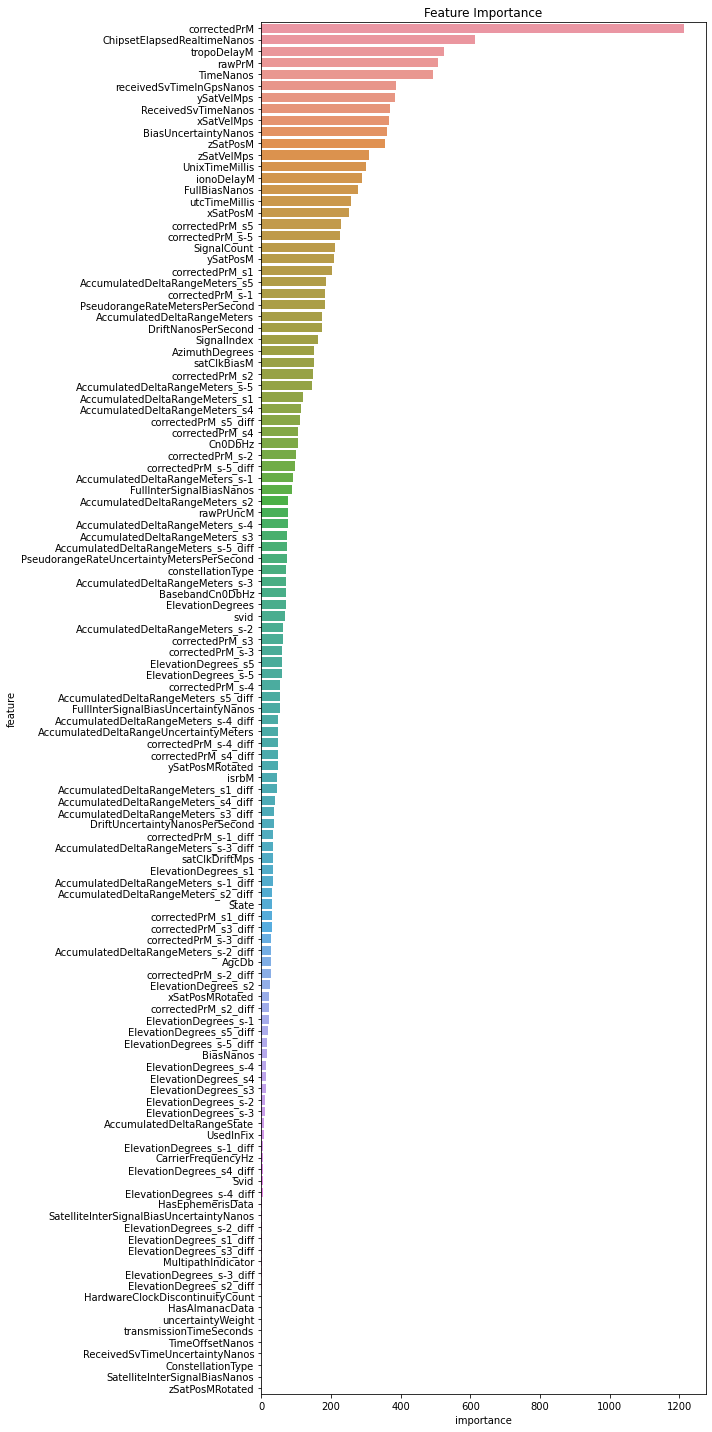

In [61]:
imp_mean = imp.groupby('feature').mean().reset_index()
plt.figure(figsize=(10, 20))
sns.barplot(x="importance", y="feature", data=imp_mean.sort_values(by="importance", ascending=False))
plt.title("Feature Importance")
plt.tight_layout()

In [ ]:
oof.to_csv(OUTPUT + '/ppredoof.csv', index=False)
test.to_csv(OUTPUT + '/ppred_test.csv', index=False)

In [ ]:
oof['phone'].value_counts()

# baseline計算

In [ ]:
def calc_baseline(args):    
    phone, df = args
    df = df[df['ElevationDegrees']>=31].copy()
    df = df[df['UsedInFix']>=1].copy()
    df = df[df['Cn0DbHz']>=20].copy()
    
    train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    train = train[train['phone']==phone].copy()
    
    s_list = []
    n_list = []
    lat_list = []
    lng_list = []
    unc_mean_list = []
    unc_max_list = []
    
    
    for ms in train['millisSinceGpsEpoch'].unique():
        tmp = df[df['millisSinceGpsEpoch']==ms].copy()
        n = tmp['svid'].nunique()
        s_list.append(ms)
        n_list.append(n)
        
        if n < 4:    
            lat_list.append(np.nan)
            lng_list.append(np.nan)
            unc_mean_list.append(np.nan)
            unc_max_list.append(np.nan)        
        
        else:
            res = calc_baseline_point(tmp)
            lat_list.append(res[0])
            lng_list.append(res[1])
            unc_mean_list.append(tmp['uncertaintyWeight'].mean())
            unc_max_list.append(tmp['uncertaintyWeight'].max())
    
    output_df = pd.DataFrame()
    output_df['millisSinceGpsEpoch'] = s_list
    output_df['latDeg'] = lat_list
    output_df['lngDeg'] = lng_list
    output_df['n'] = n_list
    output_df['unc_mean'] = unc_mean_list
    output_df['unc_max'] = unc_max_list
    output_df['phone'] = phone
    
    return output_df

In [ ]:
def calc_baseline_point(df):

    def distance(sat_pos, x):
        sat_pos_diff = sat_pos.copy(deep=True)

        sat_pos_diff['xSatPosMRotated'] = sat_pos_diff['xSatPosMRotated'] - x[0]
        sat_pos_diff['ySatPosMRotated'] = sat_pos_diff['ySatPosMRotated'] - x[1]
        sat_pos_diff['zSatPosMRotated'] = sat_pos_diff['zSatPosMRotated'] - x[2]

        sat_pos_diff['d'] = sat_pos_diff['uncertaintyWeight'] * \
                            (np.sqrt((sat_pos_diff['xSatPosMRotated']**2 + sat_pos_diff['ySatPosMRotated']**2 + sat_pos_diff['zSatPosMRotated']**2)) + \
                             x[3] - sat_pos_diff['P_pred'])

        return sat_pos_diff['d']

    def distance_fixed_satpos(x):
        return distance(df[['xSatPosMRotated', 'ySatPosMRotated', 'zSatPosMRotated', 'P_pred', 'uncertaintyWeight']], x)
    
    x0 = [0,0,0,0]
    opt_res = opt.least_squares(distance_fixed_satpos, x0)
    # Optimiser yields a position in the ECEF coordinates
    opt_res_pos = opt_res.x
    
    # ECEF position to lat/long
    wls_estimated_pos = ecef2lla(*opt_res_pos[:3])
    wls_estimated_pos = np.squeeze(wls_estimated_pos)
    
    return wls_estimated_pos[0], wls_estimated_pos[1]

In [ ]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(calc_baseline, oof.groupby('phone'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
result = pd.concat(dfs)

In [ ]:
train, test, sub, gt = get_data()
gt['phone'] = gt['collectionName'] + '_' + gt['phoneName']
gt_tmp = gt[['phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']].copy()
gt_tmp.columns = ['phone', 'millisSinceGpsEpoch', 'latDeg_gt', 'lngDeg_gt']
result = result.merge(gt_tmp, on=['phone', 'millisSinceGpsEpoch'], how='left')
result['rb_gt_err'] = calc_haversine(result['latDeg_gt'], result['lngDeg_gt'], result['latDeg'], result['lngDeg'])

In [ ]:
for phone in result['phone'].unique():
    tmp = result[result['phone']==phone].copy()
    null_rate = tmp['latDeg'].isnull().sum() / len(tmp)
    print(phone, null_rate)

In [ ]:
result_grouped = result.dropna().groupby('phone')['rb_gt_err'].agg([percentile50, percentile95]).reset_index()
result_grouped.columns = ['phone', 'rb_gt_err_p50', 'rb_gt_err_p95']
result_grouped['rb_score'] = (result_grouped['rb_gt_err_p95'] + result_grouped['rb_gt_err_p50']) / 2
result_grouped

In [ ]:
result_grouped[['rb_score']].mean()